In [ ]:
import pandas as pd
import nltk
import string
import re
from transformers import AutoTokenizer, AutoModelForTokenClassification
! pip install datasets
%pip install transformers
%pip install spacy
%pip install torch
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval
from datasets import load_dataset, load_metric
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [ ]:
short_dataset = dataset["train"][:200]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

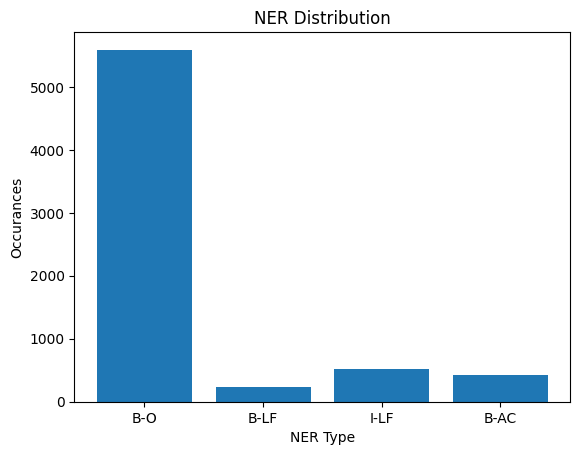

In [ ]:
from collections import Counter

tokens = short_dataset["tokens"]
ner_tags = short_dataset["ner_tags"]

df = pd.DataFrame({"tokens": tokens, "ner_tags": ner_tags})

ner_counter = Counter()
for tags in ner_tags:
  for tag in tags:
    ner_counter[tag] += 1

plt.bar(ner_counter.keys(), ner_counter.values())
plt.xlabel("NER Type")
plt.ylabel("Occurances")
plt.title("NER Distribution")
plt.show()


In [ ]:
tokenized_input = tokenizer(short_dataset["tokens"], is_split_into_words=True)

In [ ]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

label_list = []
for sample in short_dataset["ner_tags"]:
    label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in val_dataset["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in test_dataset["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])

In [ ]:
def tokenize_and_align_labels(short_dataset, list_name):
    tokenized_inputs = tokenizer(short_dataset["tokens"], truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = tokenize_and_align_labels(short_dataset, label_list)
tokenized_val_datasets = tokenize_and_align_labels(val_dataset, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_dataset, test_label_list)

In [ ]:
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

In [ ]:
tokenised_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenised_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenised_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
import numpy as np

metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

<ipython-input-12-7c72ccf86762>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=300, training_loss=0.23307909647623698, metrics={'train_runtime': 1251.1275, 'train_samples_per_second': 0.959, 'train_steps_per_second': 0.24, 'total_flos': 46005392081664.0, 'train_loss': 0.23307909647623698, 'epoch': 6.0})

In [ ]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results



{'0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]': {'precision': 0.6231454005934718,
  'recall': 0.7865168539325843,
  'f1': 0.6953642384105959,
  'number': 267},
 '0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0]': {'precision': 0.5658914728682171,
  'recall': 0.6809701492537313,
  'f1': 0.6181202370872142,
  'number': 536},
 '0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0]': {'precision': 0.5795454545454546,
  'recall': 0.6845637583892618,
  'f1': 0.6276923076923077,
  'number': 149},
 '1, 0, 2, 3, 3, 0]': {'precision': 0.5379746835443038,
  'recall': 0.6589147286821705,
  'f1': 0.5923344947735191,
  'number': 129},
 'overall_precision': 0.5790273556231003,
 'overall_recall': 0.7049028677150786,
 'overall_f1': 0.6357947434292867,
 'overall_accuracy': 0.9145993083746805}

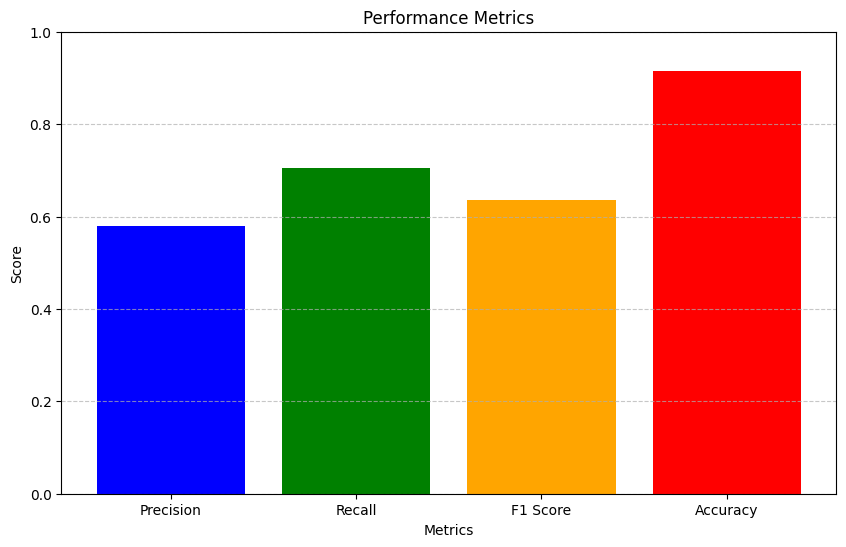

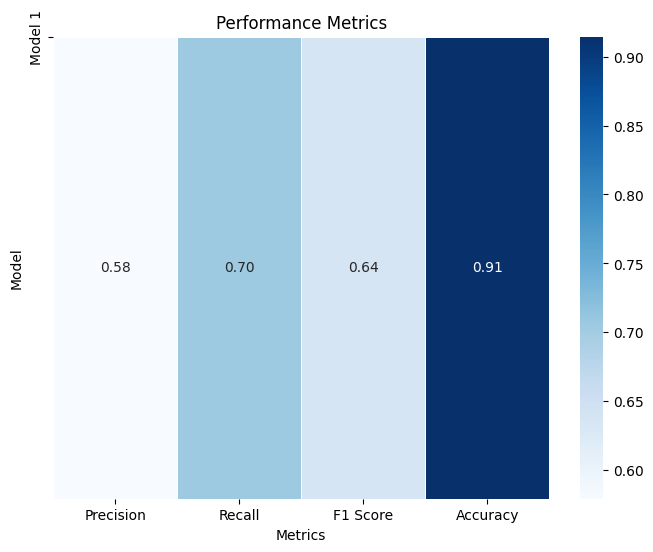

In [ ]:

def sparse_metrics(true_predictions, true_labels):
    results = metric.compute(predictions=true_predictions, references=true_labels)
    precision = results["overall_precision"]
    recall = results["overall_recall"]
    f1 = results["overall_f1"]
    accuracy = results["overall_accuracy"]

    metrics = csr_matrix([[precision, recall, f1, accuracy]])

    return metrics

test_results = sparse_metrics(true_predictions, true_labels)

precision = test_results[0, 0]
recall = test_results[0, 1]
f1 = test_results[0, 2]
accuracy = test_results[0, 3]

metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]

dense_results = test_results.toarray()

plt.figure(figsize=(10, 6))
plt.bar(metrics, dense_results[0], color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

metrics_df = pd.DataFrame(dense_results, columns=metrics)

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Performance Metrics")
plt.xlabel("Metrics")
plt.ylabel("Model")
plt.yticks([0], ['Model 1'])
plt.show()

**Hyper-Parameter optimization**

Lower learning rate value, lower Batch size, lower epochs

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 3
batch_size = 2
learning_rate = 1e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=300, training_loss=0.05805732727050781, metrics={'train_runtime': 741.5332, 'train_samples_per_second': 0.809, 'train_steps_per_second': 0.405, 'total_flos': 18615689137056.0, 'train_loss': 0.05805732727050781, 'epoch': 3.0})

In [ ]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [1, 0, 2, 3, 3, 0] seems not to be NE tag.
  warnings.warn('{} seems not t

{'0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]': {'precision': 0.6612903225806451,
  'recall': 0.7677902621722846,
  'f1': 0.7105719237435008,
  'number': 267},
 '0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0]': {'precision': 0.5852090032154341,
  'recall': 0.6791044776119403,
  'f1': 0.6286701208981003,
  'number': 536},
 '0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0]': {'precision': 0.5675675675675675,
  'recall': 0.7046979865771812,
  'f1': 0.6287425149700598,
  'number': 149},
 '1, 0, 2, 3, 3, 0]': {'precision': 0.5398773006134969,
  'recall': 0.6821705426356589,
  'f1': 0.6027397260273973,
  'number': 129},
 'overall_precision': 0.5953125,
 'overall_recall': 0.7049028677150786,
 'overall_f1': 0.6454891994917408,
 'overall_accuracy': 0.9173056683205533}

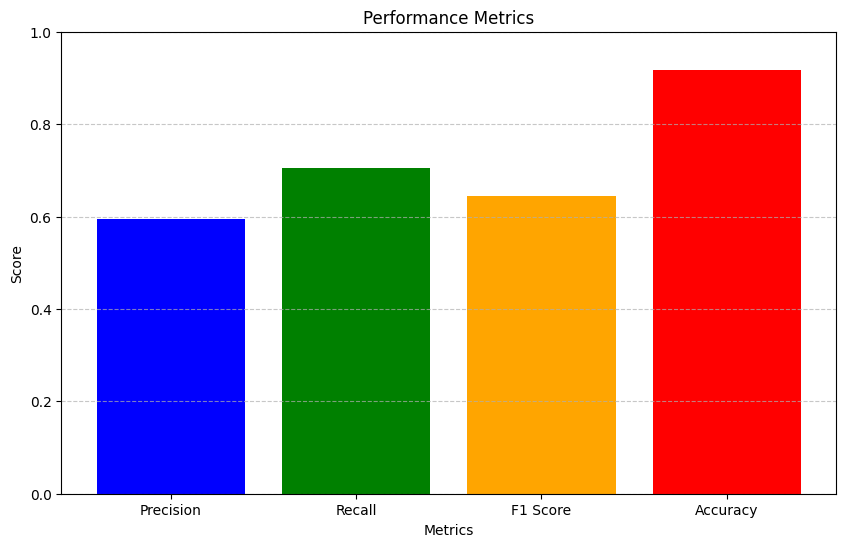

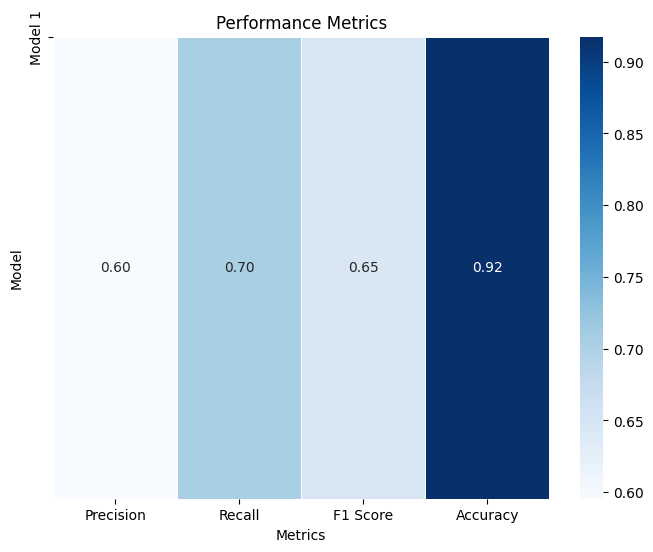

In [ ]:
def sparse_metrics(true_predictions, true_labels):
    results = metric.compute(predictions=true_predictions, references=true_labels)
    precision = results["overall_precision"]
    recall = results["overall_recall"]
    f1 = results["overall_f1"]
    accuracy = results["overall_accuracy"]

    metrics = csr_matrix([[precision, recall, f1, accuracy]])

    return metrics

test_results = sparse_metrics(true_predictions, true_labels)

precision = test_results[0, 0]
recall = test_results[0, 1]
f1 = test_results[0, 2]
accuracy = test_results[0, 3]

metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]

dense_results = test_results.toarray()

plt.figure(figsize=(10, 6))
plt.bar(metrics, dense_results[0], color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

metrics_df = pd.DataFrame(dense_results, columns=metrics)

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Performance Metrics")
plt.xlabel("Metrics")
plt.ylabel("Model")
plt.yticks([0], ['Model 1'])
plt.show()

Higher learning rate value, lower Batch size, lower epochs

In [ ]:
# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 3
batch_size = 2
learning_rate = 4e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=300, training_loss=0.07372966130574544, metrics={'train_runtime': 755.131, 'train_samples_per_second': 0.795, 'train_steps_per_second': 0.397, 'total_flos': 18615689137056.0, 'train_loss': 0.07372966130574544, 'epoch': 3.0})

In [ ]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [1, 0, 2, 3, 3, 0] seems not to be NE tag.
  warnings.warn('{} seems not t

{'0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]': {'precision': 0.6553846153846153,
  'recall': 0.797752808988764,
  'f1': 0.7195945945945945,
  'number': 267},
 '0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0]': {'precision': 0.584375,
  'recall': 0.6977611940298507,
  'f1': 0.6360544217687074,
  'number': 536},
 '0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0]': {'precision': 0.5978260869565217,
  'recall': 0.738255033557047,
  'f1': 0.6606606606606606,
  'number': 149},
 '1, 0, 2, 3, 3, 0]': {'precision': 0.5740740740740741,
  'recall': 0.7209302325581395,
  'f1': 0.6391752577319588,
  'number': 129},
 'overall_precision': 0.6025934401220442,
 'overall_recall': 0.730804810360777,
 'overall_f1': 0.6605351170568561,
 'overall_accuracy': 0.9158021350172907}

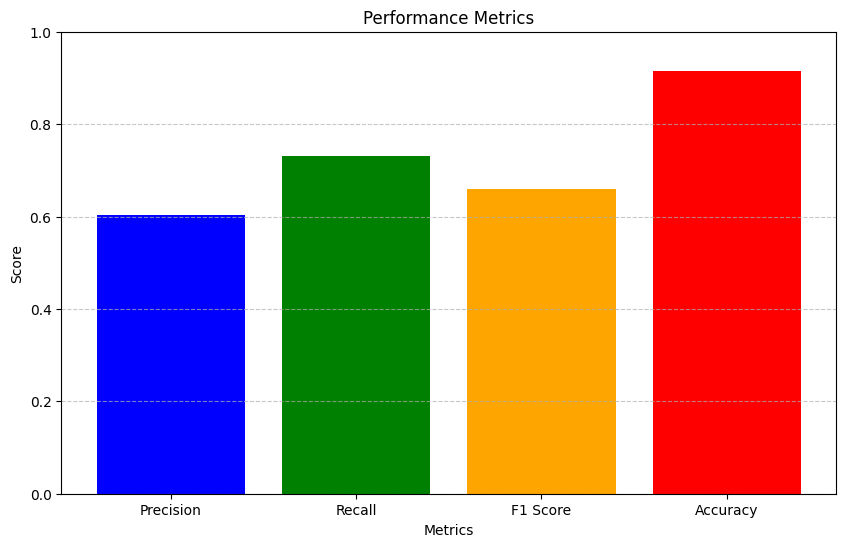

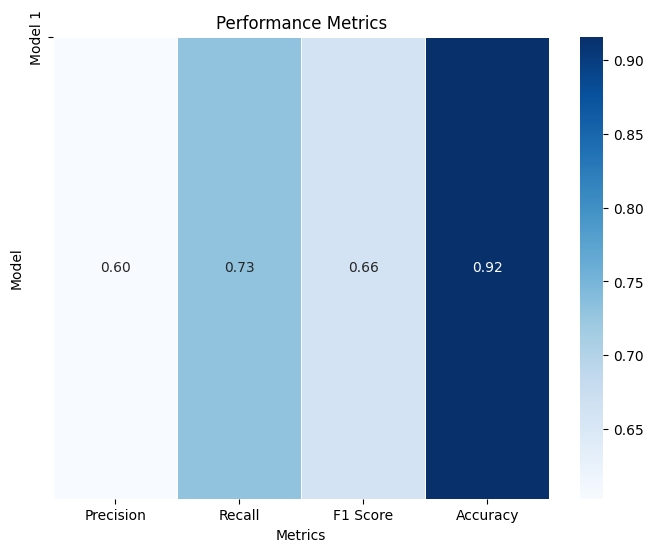

In [ ]:
def sparse_metrics(true_predictions, true_labels):
    results = metric.compute(predictions=true_predictions, references=true_labels)
    precision = results["overall_precision"]
    recall = results["overall_recall"]
    f1 = results["overall_f1"]
    accuracy = results["overall_accuracy"]

    metrics = csr_matrix([[precision, recall, f1, accuracy]])

    return metrics

test_results = sparse_metrics(true_predictions, true_labels)

precision = test_results[0, 0]
recall = test_results[0, 1]
f1 = test_results[0, 2]
accuracy = test_results[0, 3]

metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]

dense_results = test_results.toarray()

plt.figure(figsize=(10, 6))
plt.bar(metrics, dense_results[0], color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

metrics_df = pd.DataFrame(dense_results, columns=metrics)

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Performance Metrics")
plt.xlabel("Metrics")
plt.ylabel("Model")
plt.yticks([0], ['Model 1'])
plt.show()

Higher learning rate value, lower Batch size, higher epochs

In [ ]:
# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 12
batch_size = 2
learning_rate = 4e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1200, training_loss=0.016883924454450607, metrics={'train_runtime': 2820.4265, 'train_samples_per_second': 0.851, 'train_steps_per_second': 0.425, 'total_flos': 74344354314432.0, 'train_loss': 0.016883924454450607, 'epoch': 12.0})

In [ ]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [1, 0, 2, 3, 3, 0] seems not to be NE tag.
  warnings.warn('{} seems not t

{'0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]': {'precision': 0.649390243902439,
  'recall': 0.797752808988764,
  'f1': 0.7159663865546219,
  'number': 267},
 '0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0]': {'precision': 0.5961538461538461,
  'recall': 0.6940298507462687,
  'f1': 0.6413793103448275,
  'number': 536},
 '0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0]': {'precision': 0.6416184971098265,
  'recall': 0.7449664429530202,
  'f1': 0.6894409937888198,
  'number': 149},
 '1, 0, 2, 3, 3, 0]': {'precision': 0.5935483870967742,
  'recall': 0.7131782945736435,
  'f1': 0.6478873239436619,
  'number': 129},
 'overall_precision': 0.615625,
 'overall_recall': 0.72895467160037,
 'overall_f1': 0.6675137653536637,
 'overall_accuracy': 0.914298601714028}

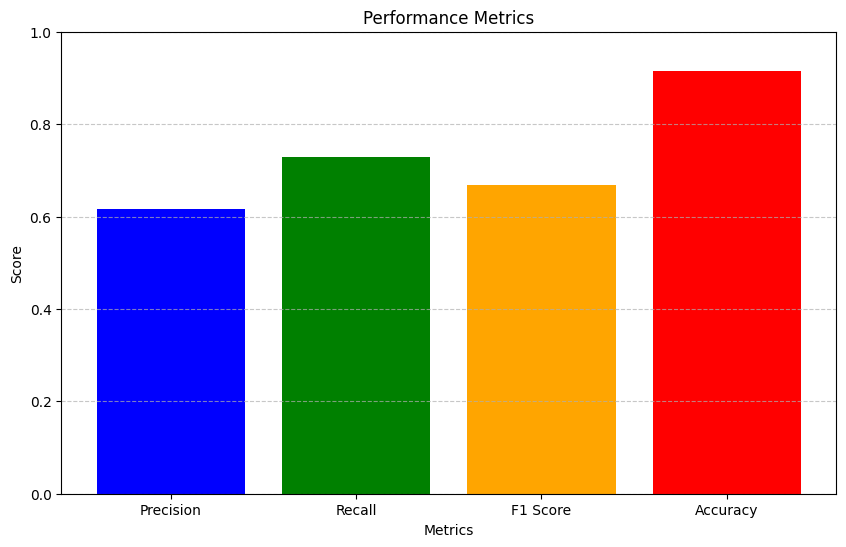

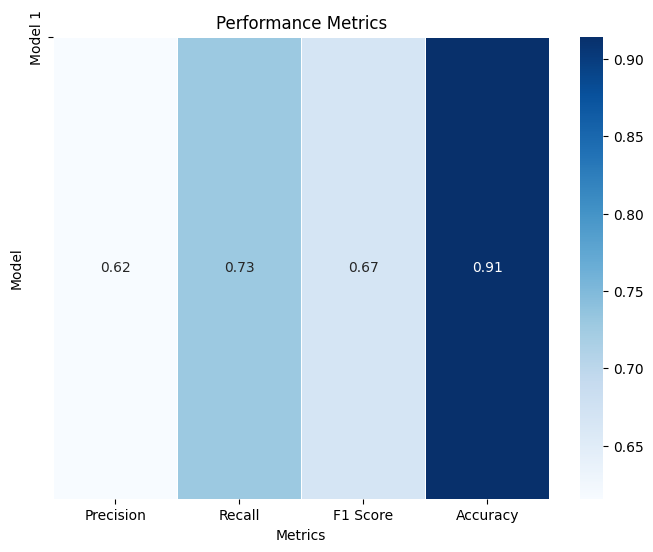

In [ ]:
def sparse_metrics(true_predictions, true_labels):
    results = metric.compute(predictions=true_predictions, references=true_labels)
    precision = results["overall_precision"]
    recall = results["overall_recall"]
    f1 = results["overall_f1"]
    accuracy = results["overall_accuracy"]

    metrics = csr_matrix([[precision, recall, f1, accuracy]])

    return metrics

test_results = sparse_metrics(true_predictions, true_labels)

precision = test_results[0, 0]
recall = test_results[0, 1]
f1 = test_results[0, 2]
accuracy = test_results[0, 3]

metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]

dense_results = test_results.toarray()

plt.figure(figsize=(10, 6))
plt.bar(metrics, dense_results[0], color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

metrics_df = pd.DataFrame(dense_results, columns=metrics)

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Performance Metrics")
plt.xlabel("Metrics")
plt.ylabel("Model")
plt.yticks([0], ['Model 1'])
plt.show()

Higher learning rate value, higher Batch size, higher epochs

In [ ]:
# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 12
batch_size = 8
learning_rate = 4e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=300, training_loss=0.002952066659927368, metrics={'train_runtime': 2466.7765, 'train_samples_per_second': 0.973, 'train_steps_per_second': 0.122, 'total_flos': 110595852033024.0, 'train_loss': 0.002952066659927368, 'epoch': 12.0})

In [ ]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [1, 0, 2, 3, 3, 0] seems not to be NE tag.
  warnings.warn('{} seems not t

{'0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]': {'precision': 0.6390532544378699,
  'recall': 0.8089887640449438,
  'f1': 0.7140495867768595,
  'number': 267},
 '0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0]': {'precision': 0.5548780487804879,
  'recall': 0.6791044776119403,
  'f1': 0.6107382550335572,
  'number': 536},
 '0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0]': {'precision': 0.6368715083798883,
  'recall': 0.7651006711409396,
  'f1': 0.6951219512195123,
  'number': 149},
 '1, 0, 2, 3, 3, 0]': {'precision': 0.5847953216374269,
  'recall': 0.7751937984496124,
  'f1': 0.6666666666666667,
  'number': 129},
 'overall_precision': 0.5907738095238095,
 'overall_recall': 0.7345050878815911,
 'overall_f1': 0.6548453608247423,
 'overall_accuracy': 0.9091865884829349}

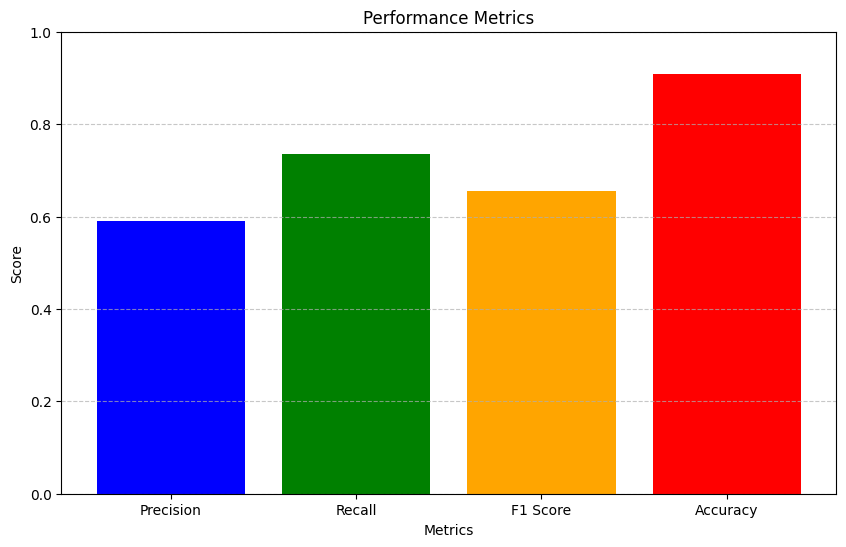

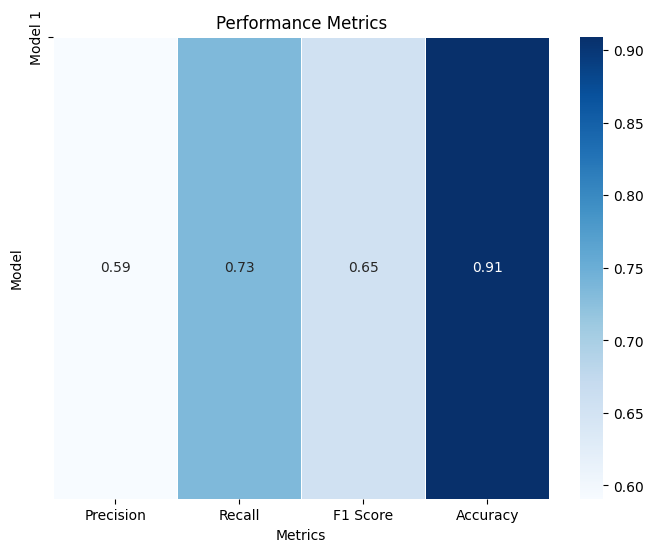

In [ ]:
def sparse_metrics(true_predictions, true_labels):
    results = metric.compute(predictions=true_predictions, references=true_labels)
    precision = results["overall_precision"]
    recall = results["overall_recall"]
    f1 = results["overall_f1"]
    accuracy = results["overall_accuracy"]

    metrics = csr_matrix([[precision, recall, f1, accuracy]])

    return metrics

test_results = sparse_metrics(true_predictions, true_labels)

precision = test_results[0, 0]
recall = test_results[0, 1]
f1 = test_results[0, 2]
accuracy = test_results[0, 3]

metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]

dense_results = test_results.toarray()

plt.figure(figsize=(10, 6))
plt.bar(metrics, dense_results[0], color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

metrics_df = pd.DataFrame(dense_results, columns=metrics)

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Performance Metrics")
plt.xlabel("Metrics")
plt.ylabel("Model")
plt.yticks([0], ['Model 1'])
plt.show()